In [109]:
import pandas as pd
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

# 1.Load data

In [110]:
annotations = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/12_concatenated/annotations.tsv", sep="\t", index_col=[0,1,2,3])
insertion_level_LFCs = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/16_insertion_level_curve_fitting/insertions_LFC_fitted.tsv", sep="\t", index_col=[0,1,2,3])
gene_level_LFCs = pd.read_csv("/data/c/yangyusheng_optimized/DIT_HAP_pipeline/results/HD_DIT_HAP/18_gene_level_curve_fitting/Gene_level_statistics_fitted.tsv", sep="\t", index_col=0)

genes_with_wrong_DIT_HAP = [
    "hul6",
    "sca1",
    "pmc3",
    "ymr1",
    "mkh1",
    "msn5",
    "tsc2",
    "phi1",
    "mal1",
    "num1",
    "vps1301",
    "SPCC24B10.18",
]

selected_genes = [
    "alm1",
    "atp25",
    "bst1",
    "cdc12",
    "cdc15",
    "cdc7",
    "cdk9",
    "cid14",
    "cog6",
    "cwf24",
    "cwf3",
    "dbl2",
    "dcp1",
    "dfr1",
    "esf1",
    "eso1",
    "fcp1",
    "gmh4",
    "gpi17",
    "gpi18",
    "hfi1",
    "hsf1",
    "its3",
    "mcm4",
    "mdm34",
    "met9",
    "mis6",
    "mms19",
    "mre11",
    "nbs1",
    "not1",
    "nup189",
    "pan1",
    "peg1",
    "pep3",
    "rib2",
    "rib7",
    "rlp7",
    "rpt2",
    "sec8",
    "sip1",
    "sog2",
    "spt7",
    "ssr2",
    "tfg1",
    "tif471",
    "tpr1",
    "uba2",
    "vps11",
    "vps16",
    "lsh1",
    "cdc12",
    "gpi18",
    "cid14",
    "efg1",
    "tup12",
    "mrp11",
    "atp25",
    "mre11",
    "sld3",
    "wrs1",
    "prh1",
    "mis6",
    "meu31",
    "met9",
    "cdc15",
    "taf2",
    "cdc123",
    "vps41",
    "bst1",
    "rlp7",
    "bfr2",
    "ulp2",
    "swc4",
    "rpn9",
    "pst2",
    "fta2",
    "cit1",
    "trl1",
    "ssr2",
    "vps11",
    "rpp101",
    "vma5",
    "abo1",
    "peg1",
    "ntr1",
    "alm1",
    "nup189",
    "sen1",
    "rpl702",
    "mms19",
    "pub1",
    "its3",
    "pan1",
    "tif471",
    "tpr1",
    "hsf1",
    "sea3",
    "ino80",
    "sip1",
    "mtr10",
    "uba2",
    "pdc2",
    "ucp3",
    "ste20",
    "cyr1",
    "taf51",
    "cwf24",
    "naf1",
    "rsm27",
    "cog6",
    "cdc7",
    "spt7",
    "imp2",
    "cbp1",
    "sog2",
    "hfi1",
    "tad2",
    "ani1",
    "cnp3",
    "eso1",
    "utp6",
    "cog3",
    "dbl2",
    "rib2",
    "sec8",
    "asp1",
    "mcm4",
    "cwf5",
    "git3",
    "ekc1",
    "ksg1",
    "tfg1",
    "bdp1",
    "pep3",
    "syp1",
    "med14",
    "nse6",
    "lid2",
    "cut8",
    "tfa2",
    "dia4",
    "drp1",
    "mrpl1",
    "rpc2",
    "mcb1",
    "pog1",
    "mor2",
    "rpm2",
    "ssr3",
    "fab1",
    "hem15",
    "pcp1",
    "ams2",
    "dbp5",
    "rpn7",
    "los1",
    "zas1",
    "stt4",
    "mrpl10",
    "mrp51",
    "ero12",
    "mms1",
    "raf2",
    "dna2",
    "gpi12",
    "ssr4",
    "omh6",
    "cup1",
    "sin1",
    "nup120",
    "tim23",
    "yta12",
    "rrp9",
    "smi1",
    "rng3",
    "rad52",
    "pdi1",
    "nnk1",
    "rok1",
    "alp5",
    "iml1",
    "ppp1",
    "elp1",
    "urb1",
    "SPAC8F11.04",
    "npl4",
    "cul4",
    "sgd1",
    "gta1",
    "rpc17",
    "end4",
    "hmg1",
    "vam6",
    "syf2",
    "isa1",
    "cwf25",
    "enp1",
    "rrp6",
    "cwf4",
    "sec39",
    "sfb3",
    "pef1",
    "tti1",
    "utp14",
    "mpe1",
    "gem1",
    "SPBC15D4.11c",
    "rna15",
    "etd1",
    "eca39",
    "mrps26",
    "for3",
    "fkh2",
    "cnx1",
    "rce1",
    "cut4",
    "tpz1",
    "cut20",
    "lac1",
    "cut23",
    "mis18",
    "mis14",
    "its8",
    "srb4",
    "cnp20",
    "mrp20",
    "ned1",
    "ptr8",
    "aur1",
    "vid21",
    "oct1",
    "SPAC806.02c",
    "tim50",
    "mis19",
    "tit1",
    "pep12",
    "zip1",
    "myo1",
    "nak1",
    "nuc2",
    "pga1",
    "smc5",
    "arp5",
    "fes1",
    "ypt1",
    "nop16",
    "ebp2",
    "rgf3",
    "pkd2",
    "sfc1",
    "rps402",
    "trz1",
    "vps25",
    "lcb1",
    "gea1",
    "rsm7",
    "cdc13",
    "asc1",
    "ada1",
    "rng2",
    "vma8",
    "hem3",
    "rad55",
    "cog2",
    "ulp1",
    "msl1",
    "nup186",
    "saf3",
    "pfd6",
    "cft1",
    "ppc89",
    "pob1",
    "dpm3",
    "enp2",
    "nup85",
    "pir2",
    "mdj1",
    "npp106",
    "fta4",
    "erd1",
    "cdc28",
    "rsd1",
    "flx1",
    "SPCC613.08",
    "plc1",
    "git7",
    "pct1",
    "yml6",
    "tho7",
    "tif303",
    "ini1",
    "prp43",
    "grn1",
    "bpl1",
    "tho5",
    "lip2",
    "rrn7",
    "scj1",
    "sec16",
    "orc4",
    "ura1",
    "sap62",
    "hsp78",
    "pst1",
    "cay1",
    "vps52",
    "srp21",
    "amo1",
    "rrp40",
    "rps1002",
    "rct1",
    "uso1",
    "prp16",
    "rsa1",
    "lip5",
    "ysh1",
    "nop52",
    "prp39",
    "rqh1",
    "rcl1",
    "swf1",
    "sec27",
    "nse2",
    "msw1",
    "kin1",
    "cut9",
    "prp22",
    "vps51",
    "pop100",
    "mob2",
    "tfb4",
    "ost3",
    "spf30",
    "tho1",
    "mca1",
    "cnd3",
    "emp65",
    "mcm3",
    "pfh1",
    "rfc1",
    "air1",
    "uba1",
    "med18",
    "pus7",
    "lam1",
    "cdc10",
    "naa20",
    "brr6",
    "mis15",
    "kei1",
    "taf10",
    "sec5",
    "cwf22",
    "uri1",
    "shk1",
    "vma13",
    "jmj3",
    "mrpl25",
    "omh3",
    "SPBC1861.05",
    "trz2",
    "pbn1",
    "cyb502",
    "mrpl31",
    "alp4",
    "mto1",
    "sec22",
    "krs1",
    "tsc3",
    "exo8",
    "mts4",
    "hrs1",
    "taf6",
    "sec3",
    "ufd1",
    "pof1",
    "rpf2",
    "ync13",
    "res1",
    "ckb1",
    "glo3",
    "rrp42",
    "arp8",
    "itr2",
    "sam1",
    "trs23",
    "vps901",
    "prp24",
]

gene_level_LFCs = gene_level_LFCs.query("Name not in @genes_with_wrong_DIT_HAP and Name not in @selected_genes").copy()

# 2.Define the UTRs

In [111]:
def assign_insertion_direction(insertion_strand, region_strand):
    if insertion_strand == region_strand:
        return "Forward"
    else:
        return "Reverse"


def assign_UTR_type(row):
    left_gene, right_gene = row["Name"].split("|")
    left_strand, right_strand = row["Strand_Interval"].split("|")
    insertion_strand = row.name[2]
    Distance_to_region_start = row["Distance_to_region_start"]
    Distance_to_region_end = row["Distance_to_region_end"]
    Parental_gene = ""
    Insertion_direction = ""
    UTR_type = ""
    Distance_to_gene_boundary = 0
    if (Distance_to_region_start < 300) and (Distance_to_region_end > 300):
        Parental_gene = left_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, left_strand)
        if left_strand == "+":
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_start
        else:
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_start
    elif (Distance_to_region_start > 300) and (Distance_to_region_end < 300):
        Parental_gene = right_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, right_strand)
        if right_strand == "+":
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_end
        else:
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_end
    return Parental_gene, Insertion_direction, UTR_type, Distance_to_gene_boundary


In [112]:
UTR_insertions = annotations.query("Type == 'Intergenic region' and ((Distance_to_region_start < 100) or (Distance_to_region_end < 100))").copy()
UTR_insertions[["Parental_gene", "Insertion_direction", "UTR_type", "Distance_to_gene_boundary"]] = UTR_insertions.apply(assign_UTR_type, axis=1, result_type="expand")
UTR_insertion_LFCs = pd.merge(insertion_level_LFCs, UTR_insertions, left_index=True, right_index=True, how="inner")
UTR_insertion_LFCs = pd.merge(UTR_insertion_LFCs.reset_index(), gene_level_LFCs, left_on="Parental_gene", right_on="Name", how="inner", suffixes=("_insertion", "_gene"))
UTR_insertion_LFCs["A_ratio"] = UTR_insertion_LFCs["A_insertion"] / UTR_insertion_LFCs["A_gene"]
UTR_insertion_LFCs["um_ratio"] = UTR_insertion_LFCs["um_insertion"] / UTR_insertion_LFCs["um_gene"]

# 3. in-gene insertions

In [113]:
in_gene_insertions = annotations.query("Type != 'Intergenic region'").copy()
in_gene_insertion_LFCs = pd.merge(insertion_level_LFCs, in_gene_insertions, left_index=True, right_index=True, how="inner")
in_gene_insertion_LFCs = pd.merge(in_gene_insertion_LFCs.reset_index(), gene_level_LFCs, on="Name", how="inner", suffixes=("_insertion", "_gene"))
in_gene_insertion_LFCs["A_ratio"] = in_gene_insertion_LFCs["A_insertion"] / in_gene_insertion_LFCs["A_gene"]
in_gene_insertion_LFCs["um_ratio"] = in_gene_insertion_LFCs["um_insertion"] / in_gene_insertion_LFCs["um_gene"]

# 4. Select the genes with growth contribution

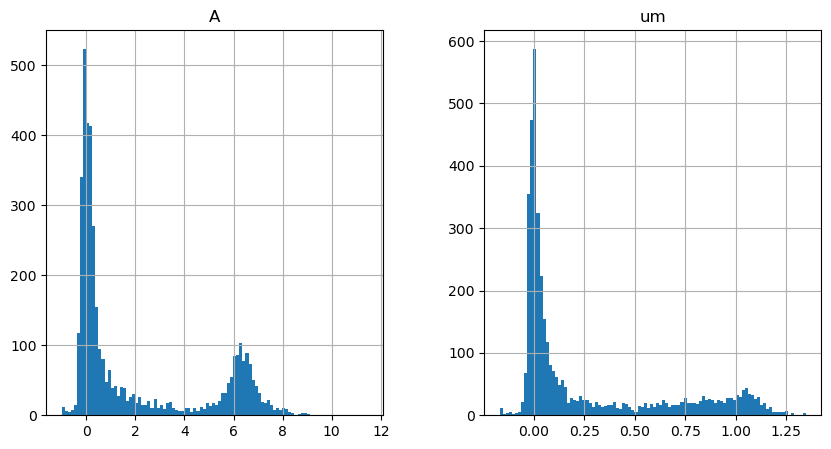

In [114]:
gene_level_LFCs[["A", "um"]].hist(bins=100, figsize=(10,5))
plt.show()
plt.close()

In [115]:
UTR_insertion_in_nonWT_genes = UTR_insertion_LFCs.query("(A_gene > 3) and (um_gene > 0.5)").copy()
in_gene_insertion_in_nonWT_genes = in_gene_insertion_LFCs.query("(A_gene > 3) and (um_gene > 0.5)").copy()

# 5.Plot

In [116]:
def plot_UTR_gene_boundary_insertions(UTR_insertions, gene_insertions, feature="um_ratio"):


    fig, axes = plt.subplots(1,4, figsize=(20,5))

    UTR_5 = UTR_insertions.query("UTR_type == '5UTR'").copy()
    N_terminal_insertions = gene_insertions.query("Distance_to_start_codon < 100").copy()
    N_terminal_insertions["Distance_to_gene_boundary"] = N_terminal_insertions["Distance_to_start_codon"]
    C_terminal_insertions = gene_insertions.query("Distance_to_stop_codon < 100").copy()
    C_terminal_insertions["Distance_to_gene_boundary"] = -C_terminal_insertions["Distance_to_stop_codon"]
    UTR_3 = UTR_insertions.query("UTR_type == '3UTR'").copy()

    titles = ["5UTR", "N-terminus", "C-terminus", "3UTR"]
    for col, col_data in enumerate([UTR_5, N_terminal_insertions, C_terminal_insertions, UTR_3]):
        ax = axes[col]
        # boxplot with bins
        width = 3
        x_bins = np.arange(-300, 301, width)
        col_data["bin"] = pd.cut(col_data["Distance_to_gene_boundary"], bins=x_bins)
        col_data["bin_mid"] = col_data["bin"].map(lambda x: x.mid)
        grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
        grouped_data = grouped_data[grouped_data.map(len) > 1]
        positions = grouped_data.index.tolist()
        boxplot_values = grouped_data.values.tolist()
        ax.boxplot(boxplot_values, positions=positions, widths=width, patch_artist=True, boxprops=dict(facecolor="grey", alpha=0.5), showfliers=False)
        ax.set_xticks([])
        x_data = col_data["Distance_to_gene_boundary"]
        y_data = col_data[feature]
        ax.scatter(x_data, y_data, alpha=0.5, s=10, facecolor="none", edgecolor="grey")
        # ax.set_xlabel("Distance to gene body (bp)")
        # ax.set_ylabel(feature)
        ax.set_title(titles[col])
        ax.set_ylim(-0.5, 2)
        ax.axhline(0, color="green", linestyle="--", linewidth=2, alpha=0.2)
        ax.axhline(1, color="red", linestyle="--", linewidth=2, alpha=0.2)
        if col > 0:
            ax.spines[["left", "top", "right"]].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines[["top", "right"]].set_visible(False)


    plt.show()
    plt.close()

/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data

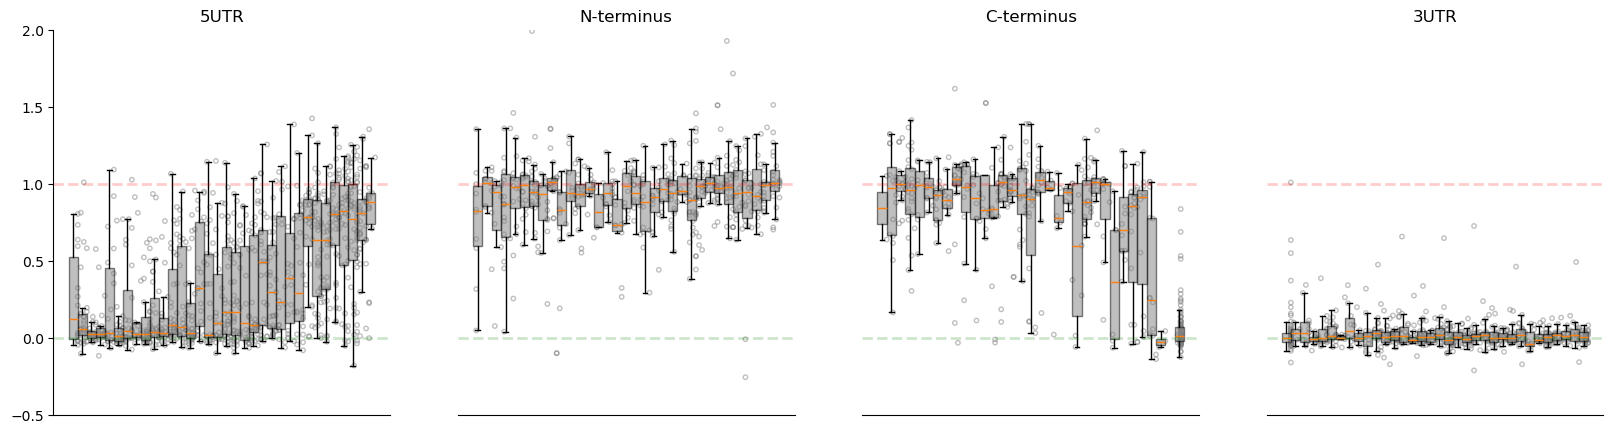

In [117]:
plot_UTR_gene_boundary_insertions(UTR_insertion_in_nonWT_genes, in_gene_insertion_in_nonWT_genes)

In [118]:
Pair_UTR_insertion_in_nonWT_genes = UTR_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()
Pair_in_gene_insertion_in_nonWT_genes = in_gene_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()

/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data

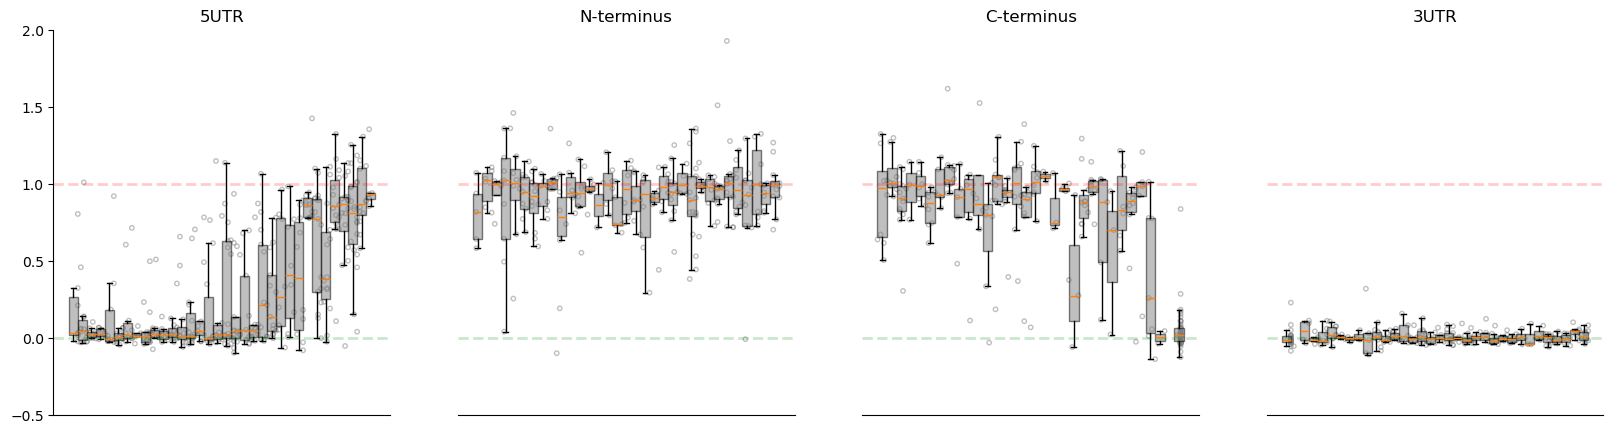

In [119]:
Forward_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
Forward_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
plot_UTR_gene_boundary_insertions(Forward_UTR_insertion_in_nonWT_genes, Forward_in_gene_insertion_in_nonWT_genes)

/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = col_data.groupby("bin_mid")[feature].apply(list).sort_index()
/tmp/ipykernel_499306/3436860303.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data

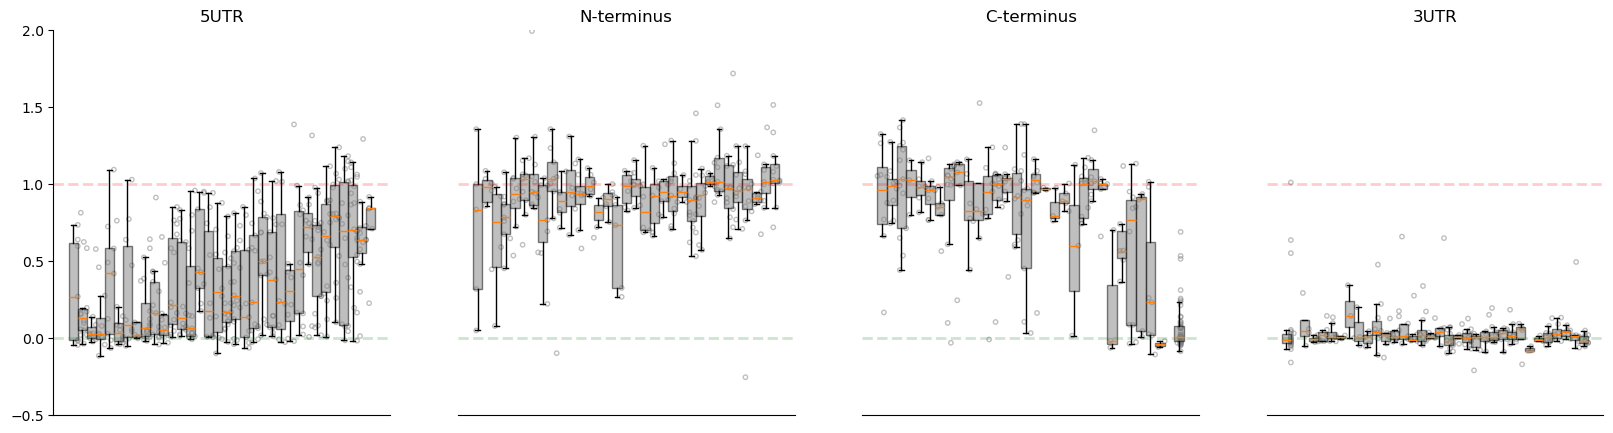

In [120]:
Reverse_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
Reverse_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
plot_UTR_gene_boundary_insertions(Reverse_UTR_insertion_in_nonWT_genes, Reverse_in_gene_insertion_in_nonWT_genes)

In [95]:
Pair_in_gene_insertion_in_nonWT_genes.query("Distance_to_start_codon < 100 or Distance_to_stop_codon < 100")

,Chr,Coordinate,Strand,Target,time_points_insertion,Status_insertion,A_insertion,um_insertion,lam_insertion,R2_insertion,RMSE_insertion,normalized_RMSE_insertion,t0_insertion,t1_insertion,t2_insertion,t3_insertion,t4_insertion,t0_fitted_insertion,t1_fitted_insertion,t2_fitted_insertion,t3_fitted_insertion,t4_fitted_insertion,t0_residual_insertion,t1_residual_insertion,t2_residual_insertion,t3_residual_insertion,t4_residual_insertion,Chr_Interval,Start_Interval,End_Interval,Transcript,Length,Strand_Interval,Feature,Systematic ID,Type,Accumulated_CDS_bases,Name,FYPOviability_insertion,DeletionLibrary_essentiality_insertion,...,ParentalRegion_end,ParentalRegion_length,Distance_to_region_start,Distance_to_region_end,Fraction_to_region_start,Fraction_to_region_end,Distance_to_start_codon,Distance_to_stop_codon,Fraction_to_start_codon,Fraction_to_stop_codon,Residue_affected,Residue_frame,Insertion_direction,FYPOviability_gene,DeletionLibrary_essentiality_gene,time_points_gene,Status_gene,A_gene,um_gene,lam_gene,R2_gene,RMSE_gene,normalized_RMSE_gene,t0_gene,t1_gene,t2_gene,t3_gene,t4_gene,t0_fitted_gene,t1_fitted_gene,t2_fitted_gene,t3_fitted_gene,t4_fitted_gene,t0_residual_gene,t1_residual_gene,t2_residual_gene,t3_residual_gene,t4_residual_gene,A_ratio,um_ratio
446,I,195490,+,TTAA,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.342,0.895,-0.000,0.981,0.273,0.052,0.0,2.312,4.545,5.244,4.924,0.353,2.105,4.316,5.117,5.293,-0.353,0.207,0.229,0.127,-0.369,I,195258,195507,SPAC13G6.11c.1,249,-,intron,SPAC13G6.11c,Coding gene,75.0,erg12,inviable,E,...,195582,1464,1372,92,0.937,0.063,92.0,1372.0,0.063,0.937,26.0,0.0,Reverse,inviable,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.903,0.988,0.563,0.998,0.096,0.016,0.0,1.863,4.405,5.595,5.856,0.176,1.771,4.479,5.583,5.833,-0.176,0.092,-0.074,0.012,0.023,0.904964,0.905870
447,I,195490,-,TTAA,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,4.715,0.770,0.140,0.987,0.206,0.044,0.0,1.923,3.454,4.660,4.621,0.261,1.703,3.701,4.481,4.662,-0.261,0.220,-0.247,0.179,-0.041,I,195258,195507,SPAC13G6.11c.1,249,-,intron,SPAC13G6.11c,Coding gene,75.0,erg12,inviable,E,...,195582,1464,1372,92,0.937,0.063,92.0,1372.0,0.063,0.937,26.0,0.0,Forward,inviable,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.903,0.988,0.563,0.998,0.096,0.016,0.0,1.863,4.405,5.595,5.856,0.176,1.771,4.479,5.583,5.833,-0.176,0.092,-0.074,0.012,0.023,0.798746,0.779352
520,I,232654,+,TTAA,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,0.686,0.115,-0.000,0.593,0.166,0.225,0.0,0.583,0.370,0.626,0.738,0.045,0.270,0.554,0.657,0.679,-0.045,0.313,-0.184,-0.031,0.059,I,231654,232665,SPAC24B11.13.1,1011,+,CDS,SPAC24B11.13,Coding gene,0.0,hem3,viable,V,...,232665,1011,1000,11,0.989,0.011,1000.0,11.0,0.989,0.011,334.0,1.0,Forward,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,6.795,1.029,1.760,0.986,0.323,0.047,0.0,0.632,4.173,5.415,6.905,0.025,0.807,3.871,5.952,6.574,-0.025,-0.175,0.302,-0.537,0.331,0.100957,0.111759
521,I,232654,-,TTAA,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,0.532,0.089,-0.000,0.042,0.252,0.338,0.0,0.554,0.747,0.409,0.231,0.035,0.210,0.430,0.510,0.527,-0.035,0.344,0.317,-0.101,-0.296,I,231654,232665,SPAC24B11.13.1,1011,+,CDS,SPAC24B11.13,Coding gene,0.0,hem3,viable,V,...,232665,1011,1000,11,0.989,0.011,1000.0,11.0,0.989,0.011,334.0,1.0,Reverse,viable,V,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,6.795,1.029,1.760,0.986,0.323,0.047,0.0,0.632,4.173,5.415,6.905,0.025,0.807,3.871,5.952,6.574,-0.025,-0.175,0.302,-0.537,0.331,0.078293,0.086492
522,I,233238,+,TTAA,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,-0.075,0.012,1.361,-0.594,0.135,0.438,0.0,-0.256,-0.082,-0.130,0.053,-0.017,-0.001,-0.000,-0.000,-0.000,0.017,-0.255,-0.082,-0.130,0.053,I,233230,235053,SPAC806.02c.1,1823,-,CDS,SPAC806.02c,Coding gene,4.0,SPAC806.02c,inviable,E,...,235106,1876,8,1868,0.004,0.996,1868.0,8.0,0.996,0.004,607.0,1.0,Reverse,inviable,E,"[0.0, 2.352, 5.588, 9.104, 12.48]",Success,5.892,0.949,0.112,0.989,0.233,0.040,0.0,2.402,4.335,5.672,5.867,0.339,2.125,4